# Seed Image Generation

This notebook shows how to construct a seed dataset, which will then be used to generate a synthetic training dataset. Our work focuses on five Indic scripts: Devanagari, Gujarati, Kannada, Malayalam, and Tamil. In order to create seed images, we work with TTF font files which can be found on the web. We use the font Lohit, and for this font the TTF files can be found here: https://pagure.io/lohit). Although our work focuses on Indic languages, the following approach can easily be extended to other languages as well. 

In [22]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from PIL import Image, ImageFont, ImageDraw

# Helper Functions

Both our input seed images (used in synthetic data generation for the training dataset) and handwritten digits (test dataset) will adhere to the standard MNIST format. This means a 28x28 size digit image will be centered in a 20x20 pixel box. We leveraged the code provided in this wonderful blogpost titled "Tensorflow, MNIST and your own handwritten digits" to help MNIST-ize our data (https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4). 

In [5]:
# Helper Functions to MNIST-ize data

def getBestShift(img):
    '''
    Returns the best shift in x and y directions
    Input: 
      img: np.array
    Output:
      sx: float
      sy: float

    '''
    # Calculate the center of mass coordinates for values in the image array
    cy, cx = ndimage.measurements.center_of_mass(img)
    rows, cols = img.shape 
  
    # Apply vertical and horizontal shift 
    sx = np.round(cols/2.0 - cx).astype(int)
    sy = np.round(rows/2.0 - cy).astype(int)
 
    return sx, sy

def shift(img, sx, sy):
    '''
    Returns shifted version of the input image
    Input: 
        img: np.array
        sx: float
        sy: float
    Output:
        img_new: np.array

    '''
    rows, cols = img.shape
    
    M = np.float32([[1, 0, sx], [0, 1, sy]]) # Transformation matrix to shift image
    shifted = cv2.warpAffine(img, M,(cols, rows)) 
  
    return shifted

def mnistize(img):
    '''
    Returns the MNIST-ized version of the input image
    Input: 
        img: np.array
    Output:
        img_new: np.array

    '''
    # Apply Binary + Otsu thresholding on image
    # More info here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Create tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img,0,1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img,-1,1)

    rows, cols = img.shape

    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))

    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28 - cols)/2.0)), int(np.floor((28 - cols)/2.0)))
    rowsPadding = (int(np.ceil((28 - rows)/2.0)), int(np.floor((28 - rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding, colsPadding), 'constant')

    # Find and apply best shift 
    shiftx, shifty = getBestShift(img)
    img_new = shift(img, shiftx, shifty)

    return img_new

We have one more helper function to take in a glyph (character) and create an image in the specified font. We will be using the Lohit family of fonts for the 5 languages.

In [6]:
def glyph_to_image(glyph, ttf_path, font_size, viz=False):
    '''
    Returns an MNIST sized version of the input glyph
    Input: 
        glyph: str
        ttf_path: str (ttf file path)
        font_size: int
    Output:
        image: np.array 
    '''
    image = Image.new('L', (28, 28))
    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype(ttf_path, font_size)
    draw.text((0, 0), glyph, font=font, fill=(255))  
 
    if(viz): # Optional visualization 
        plt.imshow(np.array(image))
        plt.title(i)
        plt.axis('off')  
    
    image = np.array(image)
  
    return image

# Creating a seed digit dataset

We have put together a dataframe of glyphs and their corresponding unicode representation for the 5 languages. For example, the Unicode representations for Kannada digits can be found here: https://unicode.org/charts/PDF/U0C80.pdf. The glyphs will then be rendered using the Lohit font. 

In [18]:
df = pd.read_csv('glyphs/df_unicode_sym.csv')
df.head()

,num,unicode,glyph,language
0,0,0CE6,೦,Kannada
1,1,0CE7,೧,Kannada
2,2,0CE8,೨,Kannada
3,3,0CE9,೩,Kannada
4,4,0CEA,೪,Kannada


In [19]:
list_files = ['Lohit-Devanagari.ttf', 'Lohit-Gujarati.ttf', 'Lohit-Kannada.ttf', 'Lohit-Malayalam.ttf', 'Lohit-Tamil.ttf']
lang_list = [l.strip('Lohit-').strip('.ttf') for l in list_files]

In [21]:
# Adjust the fontsize as necessary
fontsize_dict = {'Kannada': 24, 'Tamil': 22, 'Gujarati': 24, 'Malayalam': 20, 'Devanagari': 22}

# Save all the seed images (28x28 numpy arrays) in a dictionary
dict_seeds = {}
for lang in lang_list:
    dict_seeds[lang] = np.zeros((10,28,28))

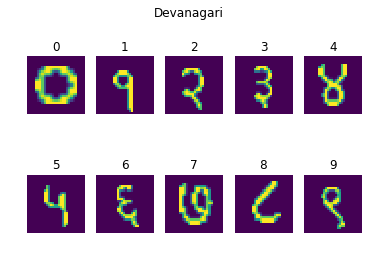

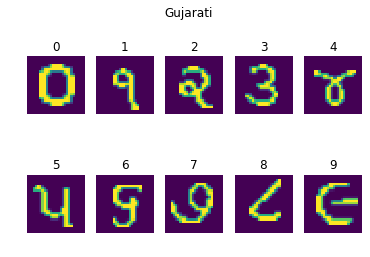

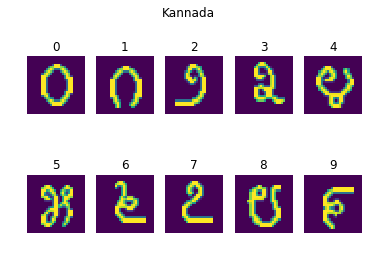

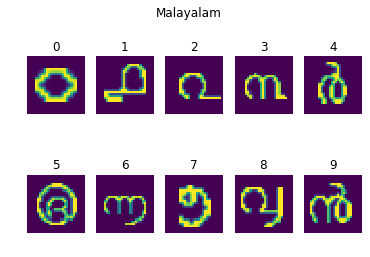

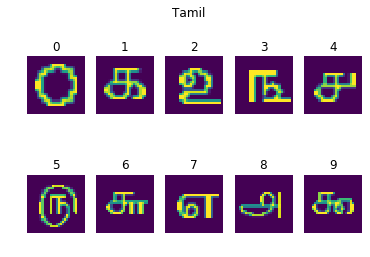

In [20]:
# Visualize MNIST-ized images of digits
for lang in lang_list:
    plt.figure()
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(dict_seeds[lang][i,:,:])
        plt.title(i)
        plt.axis('off')

    plt.suptitle(lang)

# Save the data

In [27]:
for lang in lang_list:
    filename = 'seed/seed_images_' + lang + '.npy'
    np.save(filename, dict_seeds[lang])